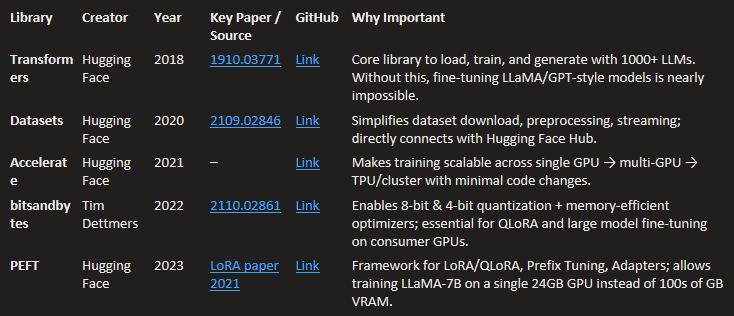

In [1]:
!pip install -U peft bitsandbytes transformers accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 136.9 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.57.2
    Uninstalling transformers-4.57.2:
      Successfully uninstalled transformers-4.57.2


In [2]:
!pip install -U trl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.5/465.5 kB 11.0 MB/s eta 0:00:00


In [3]:
!pip install PyMuPDF

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 59.9 MB/s eta 0:00:00


## Our own custom data (non instrcution data) for domain specific finetuning

In [4]:
import fitz

In [14]:
from datasets import Dataset, load_dataset


In [5]:
def extract_text_from_pdf(pdf_path):
    text_blocks = []
    with fitz.open(pdf_path) as doc:
        for page in doc:
            text = page.get_text("text").strip()
            if text:
                text_blocks.append(text)
    return text_blocks

In [6]:
pdf_texts = extract_text_from_pdf("/content/Prompt Engineering_v4.pdf")

In [8]:
pdf_texts[0]

'Prompt  \nEngineering\nAuthor: Lee Boonstra'

| Step                                     | What Happens                                                                             | Example                                     |
| ---------------------------------------- | ---------------------------------------------------------------------------------------- | ------------------------------------------- |
| **1️⃣ Data Collection**                  | Crawl text from web (Wikipedia, CommonCrawl, Books, PubMed, Code, etc.)                  | Billions of documents                       |
| **2️⃣ Cleaning / Filtering**             | Remove HTML, junk, duplicates, low-quality content                                       | Similar to your `strip()` & len filter      |
| **3️⃣ Splitting / Chunking**             | Split into paragraphs / segments using regex rules, sentence boundaries, or token length | Like your `re.split(r'\n\s*\n')`            |
| **4️⃣ Tokenization**                     | Convert text chunks → token IDs using BPE                                                | “The cat” → `[1012, 52, 199]`               |
| **5️⃣ Training (Next-Token Prediction)** | Model learns to predict the next token in each chunk                                     | Input: “The cat sat on the” → Target: “mat” |


In [9]:
import re
def split_paragraphs(pages):
    paragraphs = []
    for page_text in pages:
        # Split on double line breaks or long newlines
        chunks = re.split(r'\n\s*\n', page_text)
        for chunk in chunks:
            clean = chunk.strip()
            if len(clean) > 30:  # ignore too short lines
                paragraphs.append(clean)
    return paragraphs

In [10]:
paragraphs = split_paragraphs(pdf_texts)

In [11]:
data = [{"text": p} for p in paragraphs]

In [18]:
print(data)

[{'text': 'Prompt  \nEngineering\nAuthor: Lee Boonstra'}, {'text': 'Prompt Engineering\nSeptember 2024\n2\nAcknowledgements\nReviewers and Contributors\nMichael Sherman\nYuan Cao\nErick Armbrust\nAnant Nawalgaria\nAntonio Gulli\nSimone Cammel\nCurators and Editors\nAntonio Gulli\nAnant Nawalgaria\nGrace Mollison \nTechnical Writer\nJoey Haymaker\nDesigner\nMichael Lanning'}, {'text': 'Introduction\x08\n6\nPrompt engineering\x08\n7\nLLM output configuration\x08\n8'}, {'text': 'Putting it all together\t\n11\nPrompting techniques\x08\n12'}, {'text': 'General prompting / zero shot\x08\n13'}, {'text': 'System, contextual and role prompting\x08\n17'}, {'text': 'Contextual prompting\t\n23\nTable of contents'}, {'text': 'Automatic Prompt Engineering\x08\n40'}, {'text': 'Prompts for explaining code\t\n44'}, {'text': 'Prompts for translating code\t\n46'}, {'text': 'Prompts for debugging and reviewing code\t\n48'}, {'text': 'What about multimodal prompting?\t\n54\nBest Practices\x08\n54'}, {'text

In [15]:
dataset = Dataset.from_list(data)

In [16]:
dataset

Dataset({
    features: ['text'],
    num_rows: 80
})

## Lets Select the Model

The checkpoint is from a TinyLLaMA model trained for ~1.4M steps over 3 trillion tokens,
captured midway before final convergence.

In [19]:
# model_name = "meta-llama/Llama-2-7b-hf"
# model_name = "meta-llama/Llama-3.1-8B"
model_name = "TinyLlama/TinyLlama-1.1B-intermediate-step-1431k-3T"

In [20]:
from transformers import AutoTokenizer, AutoModelForCausalLM, Trainer, TrainingArguments, DataCollatorForLanguageModeling

In [21]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/776 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

In [22]:
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

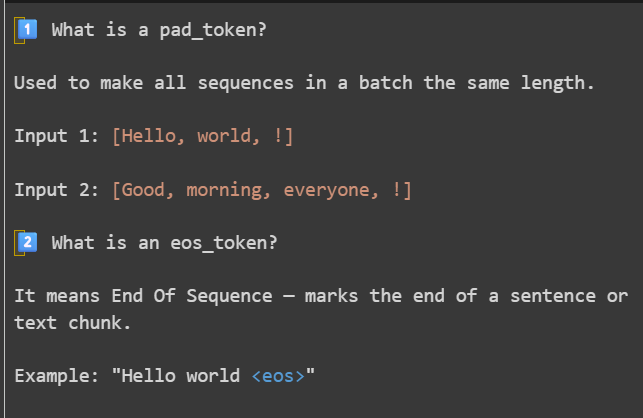

In [23]:
def tokenize_fn(examples):
    tokens = tokenizer(examples["text"],truncation=True,padding="max_length",max_length=512)
    tokens["labels"] = tokens["input_ids"].copy()
    return tokens

In [24]:
tokenized = dataset.map(tokenize_fn, batched=True, remove_columns=["text"])

Map:   0%|          | 0/80 [00:00<?, ? examples/s]

In [25]:
tokenized

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 80
})

In [26]:
model = AutoModelForCausalLM.from_pretrained(model_name)

config.json:   0%|          | 0.00/560 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/4.40G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/129 [00:00<?, ?B/s]

In [27]:
training_args = TrainingArguments(
    output_dir="./llama-pharma-domain",
    overwrite_output_dir=True,
    num_train_epochs=2,
    per_device_train_batch_size=2,
    save_steps=500,
    save_total_limit=2,
    logging_steps=50,
    learning_rate=2e-5,
    fp16=True,
    report_to="none"
)

In [28]:
from transformers import TrainingArguments
help(TrainingArguments)

Help on class TrainingArguments in module transformers.training_args:

class TrainingArguments(builtins.object)
 |  TrainingArguments(output_dir: Optional[str] = None, overwrite_output_dir: bool = False, do_train: bool = False, do_eval: bool = False, do_predict: bool = False, eval_strategy: Union[transformers.trainer_utils.IntervalStrategy, str] = 'no', prediction_loss_only: bool = False, per_device_train_batch_size: int = 8, per_device_eval_batch_size: int = 8, per_gpu_train_batch_size: Optional[int] = None, per_gpu_eval_batch_size: Optional[int] = None, gradient_accumulation_steps: int = 1, eval_accumulation_steps: Optional[int] = None, eval_delay: float = 0, torch_empty_cache_steps: Optional[int] = None, learning_rate: float = 5e-05, weight_decay: float = 0.0, adam_beta1: float = 0.9, adam_beta2: float = 0.999, adam_epsilon: float = 1e-08, max_grad_norm: float = 1.0, num_train_epochs: float = 3.0, max_steps: int = -1, lr_scheduler_type: Union[transformers.trainer_utils.SchedulerType

In [29]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized
)

In [30]:
trainer.train()

OutOfMemoryError: CUDA out of memory. Tried to allocate 44.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 18.12 MiB is free. Process 2469 has 14.72 GiB memory in use. Of the allocated memory 14.43 GiB is allocated by PyTorch, and 156.96 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

### Here we are not specfiying anything means this is full fine-tuning
### Now we have two methods for Partial Finetuning
- Feerze some layer and finetune unfreeze layer(old CNN and Bert sytel method)
- LORA(Append some external weight to the already trained pretrain weight)

### Now lets see the LORA based method

In [31]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

In [32]:
!pip install -U peft bitsandbytes transformers accelerate

In [33]:
from transformers import AutoTokenizer, AutoModelForCausalLM, TrainingArguments, Trainer
from peft import LoraConfig, get_peft_model, TaskType
from datasets import load_dataset

In [49]:
model_name = "TinyLlama/TinyLlama-1.1B-intermediate-step-1431k-3T"

In [50]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [36]:
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

In [37]:
def tokenize_fn(examples):
    tokens = tokenizer(
        examples["text"],
        truncation=True,
        padding="max_length",
        max_length=512
    )
    tokens["labels"] = tokens["input_ids"].copy()
    return tokens

In [38]:
tokenized = dataset.map(tokenize_fn, batched=True)

Map:   0%|          | 0/80 [00:00<?, ? examples/s]

In [39]:
tokenized

Dataset({
    features: ['text', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 80
})

In [51]:
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    load_in_8bit=True,
    device_map="auto"
)

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


In [52]:
lora_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM,
    r=8,
    lora_alpha=16,
    target_modules=["q_proj","v_proj"],
    lora_dropout=0.05,
    bias="none"
)

In [53]:
# save adapter
non_inst_model_lora = get_peft_model(model, lora_config)

In [54]:
args = TrainingArguments(
    output_dir="./tinyllama-lora",
    num_train_epochs=5,
    per_device_train_batch_size=1,
    gradient_accumulation_steps=8,
    learning_rate=2e-4,
    fp16=True,
    logging_steps=20,
    save_total_limit=1,
    report_to="none"
)

In [55]:
trainer = Trainer(
    model=non_inst_model_lora,
    args=args,
    train_dataset=tokenized
)

In [56]:
trainer.train()

Step,Training Loss
20,6.176800
40,2.540600


TrainOutput(global_step=50, training_loss=3.822074546813965, metrics={'train_runtime': 208.7591, 'train_samples_per_second': 1.916, 'train_steps_per_second': 0.24, 'total_flos': 1272592937779200.0, 'train_loss': 3.822074546813965, 'epoch': 5.0})

In [65]:
model_path = "/content/tinyllama-lora/checkpoint-50"

In [ ]:
# tokenizer = AutoTokenizer.from_pretrained(model_path)

In [66]:
model = AutoModelForCausalLM.from_pretrained(model_path, device_map="auto")

In [73]:
prompt = "When	you	write	a	prompt,"

In [74]:
inputs = tokenizer(prompt, return_tensors="pt").to("cuda")

In [77]:
outputs = model.generate(
    **inputs,
    max_new_tokens=100,
    temperature=0.5,
    top_p=0.9,
    do_sample=True,
    repetition_penalty=1.1
)

In [78]:
print("\nModel Output:\n")
print(tokenizer.decode(outputs[0], skip_special_tokens=True))


Model Output:

When	you	write	a	prompt,	it's	important	to	know	that	the	prompt	isn't	just	an	interactive	command.
The	prompt	is	also	used	for	authentication,	and	if	you	don't	have	credentials	or	passwords	in	your	system,	you	can	use	the	prompt	as	well.
So,	there's	a
